# PROJET 7 IMPLEMENTEZ UN MODELE DE SCORING

Home Credit Default Risk


Description

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit Group
Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

<b>Dataset Description


<b>application_{train|test}.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.


<b>bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.


<b>bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.


<b>POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.


<b>credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.


<b>previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.


<b>installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.


<b>HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

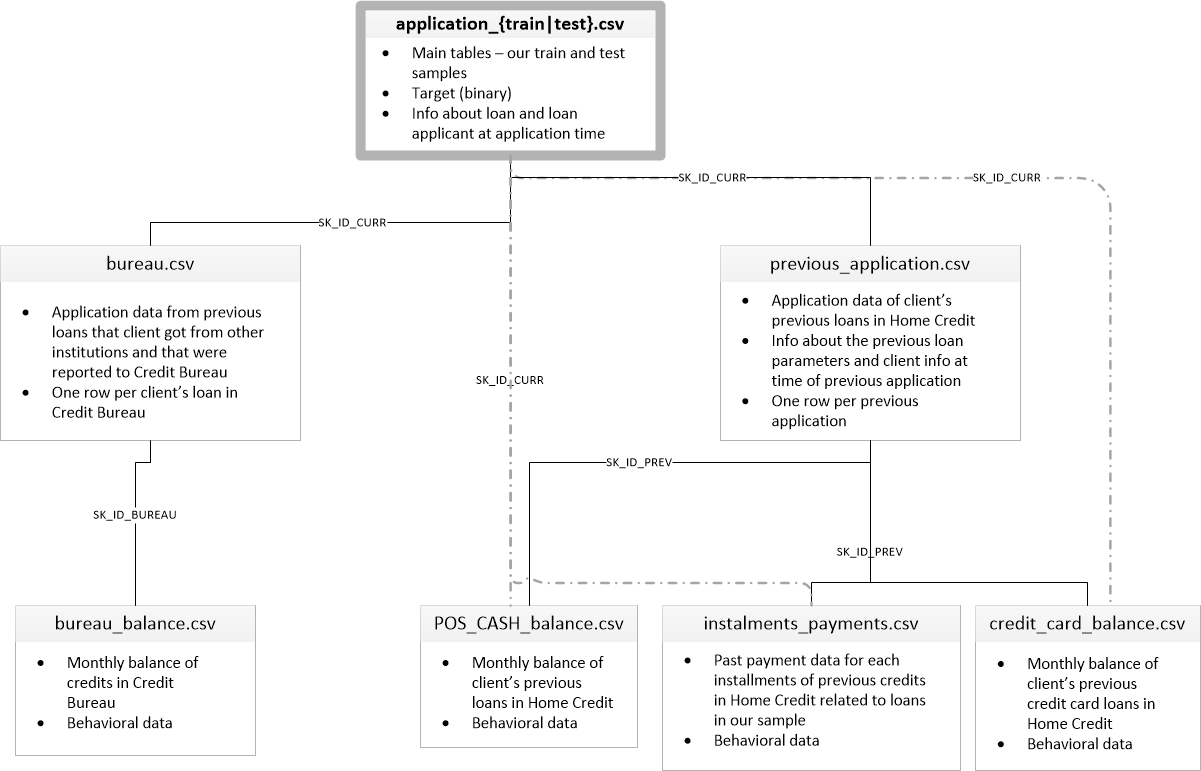

## SOMMAIRE 
### INTRODUCTION
### PARTIE I: CHOIX DU KERNEL ET ANALYSE EXPLORATOIRE
### PARTIE II: MODELISATION 
### PARTIE III: DASHBOAD 
### PARTIE IV: DEPLOIEMENT MODELE ET DASHBOARD SUR LE CLOUD 

### INTRODUCTION 

...

### PARTIE I: CHOIX DU KERNEL ET ANALYSE EXPLORATOIRE 

#### A/ LECTURE DES FICHIERS ET PREPROCESSING 

In [1]:
#conda install -c conda-forge lightgbm

In [2]:
# les librairies 
import os
import gc
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

lecture des fichiers 

In [3]:
# fonction lecture fichier csv
def read_csv(path_file):
    return pd.read_csv(path_file)

##### les fonctions preparatoires 

reduction memoire usage

In [4]:
def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

temps

In [5]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

les paramatres statistiques classiques 

In [6]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

encoding

diffence between label encoding and one hot encoding 

https://contactsunny.medium.com/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621

In [7]:
def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    """Create a new column for each categorical value in categorical columns. """
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns


def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns

les features 

In [8]:
def add_features(feature_name, aggs, features, feature_names, groupby):
    feature_names.extend(['{}_{}'.format(feature_name, agg) for agg in aggs])

    for agg in aggs:
        if agg == 'kurt':
            agg_func = kurtosis
        elif agg == 'iqr':
            agg_func = iqr
        else:
            agg_func = agg

        g = groupby[feature_name].agg(agg_func).reset_index().rename(index=str,
                                                                     columns={feature_name: '{}_{}'.format(feature_name,agg)})
        features = features.merge(g, on='SK_ID_CURR', how='left')
    return features, feature_names


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features


def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features

les groupes 

In [9]:
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()


def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)


def parallel_apply(groups, func, index_name='Index', num_workers=0, chunk_size=100000):
    if num_workers <= 0: num_workers = NUM_THREADS
    #n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
    indeces, features = [], []
    for index_chunk, groups_chunk in chunk_groups(groups, chunk_size):
        with mp.pool.Pool(num_workers) as executor:
            features_chunk = executor.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)

    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features


def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)
        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_

aggregation

In [10]:
# AGGREGATIONS
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    # Categorical
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    # Group by loan duration features (months)
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}

BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}

PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}

PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    # The following features are only for approved applications
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LATE_PAYMENTS_AGG = {
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],
}

PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

POS_CASH_AGG = {
    'SK_ID_PREV': ['nunique'],
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'SK_DPD': ['max', 'mean', 'sum', 'var'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
    'LATE_PAYMENT': ['mean']
}

INSTALLMENTS_AGG = {
    'SK_ID_PREV': ['size', 'nunique'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean', 'sum'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
    'PAID_OVER': ['mean']
}

INSTALLMENTS_TIME_AGG = {
    'SK_ID_PREV': ['size'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
}

CREDIT_CARD_AGG = {
    'MONTHS_BALANCE': ['min'],
    'AMT_BALANCE': ['max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF': ['max', 'sum'],
    'LIMIT_USE': ['max', 'mean'],
    'PAYMENT_DIV_MIN': ['min', 'mean'],
    'LATE_PAYMENT': ['max', 'sum'],
}

CREDIT_CARD_TIME_AGG = {
    'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
    'SK_DPD': ['max', 'sum'],
    'AMT_BALANCE': ['mean', 'max'],
    'LIMIT_USE': ['max', 'mean']
}

configuration

In [11]:
# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = "../input/"
SUBMISSION_SUFIX = "_model2_04"

# INSTALLMENTS TREND PERIODS
INSTALLMENTS_LAST_K_TREND_PERIODS =  [12, 24, 60, 120]

# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_FOLDS = 10
EARLY_STOPPING = 100

# LIGHTGBM_PARAMS non used in our case 

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

age label

In [12]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

le premier fichier - HomeCredit_columns_description

In [13]:
file_path_HomeCredit_columns_description = "/Users/saidali_bacar/Documents/projets_openclassrooms/projet_7/data/home_credit_default_risk/HomeCredit_columns_description.csv"

HomeCredit_columns_description = pd.read_csv(file_path_HomeCredit_columns_description, encoding='ISO-8859-1')
HomeCredit_columns_description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


le deuxieme fichier - application train 

In [14]:
file_path_application_train = "/Users/saidali_bacar/Documents/projets_openclassrooms/projet_7/data/home_credit_default_risk/application_train.csv"

application_train = pd.read_csv(file_path_application_train, encoding='ISO-8859-1')
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


le troisieme fichier - application test 

In [15]:
file_path_application_test = "/Users/saidali_bacar/Documents/projets_openclassrooms/projet_7/data/home_credit_default_risk/application_test.csv"

application_test = pd.read_csv(file_path_application_test, encoding='ISO-8859-1')
application_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


FUNCTION APPLICATION TRAIN TEST

In [16]:
#with warnings.catch_warnings():
#    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

def get_train_test(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)
    df = pd.concat([train, test], ignore_index=True)
    
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    #np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    # Time ratios
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    df = drop_application_columns(df)
    return df

def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [17]:
data_path = "/Users/saidali_bacar/Documents/projets_openclassrooms/projet_7/data/home_credit_default_risk/"
#get_train_test(data_path)

le quatrieme fichier - bureau

In [18]:
file_path_bureau = "/Users/saidali_bacar/Documents/projets_openclassrooms/projet_7/data/home_credit_default_risk/bureau.csv"

bureau = pd.read_csv(file_path_bureau, encoding='ISO-8859-1')
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


le cinquieme fichier - bureau balance

In [19]:
file_path_bureau_balance = "/Users/saidali_bacar/Documents/projets_openclassrooms/projet_7/data/home_credit_default_risk/bureau_balance.csv"

bureau_balance = pd.read_csv(file_path_bureau_balance, encoding='ISO-8859-1')
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


FUNCTION BUREAU AND BUREAU BALANCE

In [20]:
def get_bureau(path, num_rows= None):
    """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
    bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

    # One-hot encoder
    bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
    # Join bureau balance features
    bureau = bureau.merge(get_bureau_balance(path, num_rows), how='left', on='SK_ID_BUREAU')
    # Flag months with late payments (days past due)
    bureau['STATUS_12345'] = 0
    for i in range(1,6):
        bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

    # Aggregate by number of months in balance and merge with bureau (loan length agg)
    features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
        'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
    agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
    agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
    bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
    del agg_length; gc.collect()

    # General loans aggregations
    agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
    del active, closed; gc.collect()
    # Aggregations for the main loan types
    for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
        type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
        prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
        agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
        del type_df; gc.collect()
    # Time based aggregations: last x months
    for time_frame in [6, 12]:
        prefix = "BUREAU_LAST{}M_".format(time_frame)
        time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
        agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
        del time_frame_df; gc.collect()

    # Last loan max overdue
    sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
    gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
    gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
    agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
    # Ratios: total debt/total credit and active loans debt/ active loans credit
    agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
    agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']
    return agg_bureau

def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    # Calculate rate for each category with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

In [21]:
#get_bureau(data_path)

le sixieme fichier - POS_CASH_balance

In [22]:
file_path_POS_CASH_balance= "/Users/saidali_bacar/Documents/projets_openclassrooms/projet_7/data/home_credit_default_risk/POS_CASH_balance.csv"

POS_CASH_balance = pd.read_csv(file_path_POS_CASH_balance, encoding='ISO-8859-1')
POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


FUNCTION POS CASH

In [23]:
def get_pos_cash(path, num_rows= None):
    """ Process POS_CASH_balance.csv and return a pandas dataframe. """
    pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
    pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
    # Flag months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # Aggregate by SK_ID_CURR
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
    # Sort and group by SK_ID_PREV
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')
    df = pd.DataFrame()
    df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()
    # Percentage of previous loans completed and completed before initial term
    df['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df['POS_COMPLETED_BEFORE_MEAN'] = df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    # Number of remaining installments (future installments) and percentage from total
    df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()
    # Group by SK_ID_CURR and merge
    df_gp = df.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_agg = pd.merge(pos_agg, df_gp, on= 'SK_ID_CURR', how= 'left')
    del df, gp, df_gp, sort_pos; gc.collect()

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')
    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR','LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

    # Drop some useless categorical features
    drop_features = [
        'POS_NAME_CONTRACT_STATUS_Canceled_MEAN', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
        'POS_NAME_CONTRACT_STATUS_XNA_MEAN']
    pos_agg.drop(drop_features, axis=1, inplace=True)
    return pos_agg

In [24]:
#get_pos_cash(data_path)

le septieme fichier - credit_card_balance

In [25]:
file_path_credit_card_balance= "/Users/saidali_bacar/Documents/projets_openclassrooms/projet_7/data/home_credit_default_risk/credit_card_balance.csv"

credit_card_balance = pd.read_csv(file_path_credit_card_balance, encoding='ISO-8859-1')
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


FUNCTION CREDIT CARD BALANCE

In [26]:
def get_credit_card(path, num_rows= None):
    """ Process credit_card_balance.csv and return a pandas dataframe. """
    cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
    cc.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)
    # Amount used from limit
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Current payment / Min payment
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
    # Late payment
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Aggregations by SK_ID_CURR
    cc_agg = cc.groupby('SK_ID_CURR').agg(CREDIT_CARD_AGG)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg.reset_index(inplace= True)

    # Last month balance of each credit card application
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})

    # Aggregations for last x months
    for months in [12, 24, 48]:
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        cc_agg = group_and_merge(cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)
    return cc_agg

In [27]:
#get_credit_card(data_path)

le huitieme fichier - previous application

In [28]:
file_path_previous_application = "/Users/saidali_bacar/Documents/projets_openclassrooms/projet_7/data/home_credit_default_risk/previous_application.csv"

previous_application = pd.read_csv(file_path_previous_application, encoding='ISO-8859-1')
previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


FUNCTION PREVIOUS APPLICATION

In [29]:
def get_previous_applications(path, num_rows= None):
    """ Process previous_application.csv and return a pandas dataframe. """
    prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

    # One-hot encode most important categorical features
    ohe_columns = [
        'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
        'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
    prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    # Active loans - approved and not complete yet (last_due 365243)
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
    # Find how much was already payed in active loans (using installments csv)
    active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
    active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
    active_pay_agg.reset_index(inplace= True)
    # Active loans: difference of what was payed and installments
    active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
    # Merge with active_df
    active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
    active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
    active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
    # Perform aggregations for active applications
    active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
    active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                             active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
    del active_pay, active_pay_agg, active_df; gc.collect()

    # Change 365.243 values to nan (missing)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

    # Categorical features
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    # Perform general aggregations
    agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
    # Merge active loans dataframe on agg_prev
    agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
    del active_agg_df; gc.collect()
    # Aggregations for approved and refused loans
    agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
    del approved, refused; gc.collect()
    # Aggregations for Consumer loans and Cash loans
    for loan_type in ['Consumer loans', 'Cash loans']:
        type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
        prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
        agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
        del type_df; gc.collect()

    # Get the SK_ID_PREV for loans with late payments (days past due)
    pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
    dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
    # Aggregations for loans with late payments
    agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                    'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
    del agg_dpd, dpd_id; gc.collect()
    # Aggregations for loans in the last x months
    for time_frame in [12, 24]:
        time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
        prefix = 'PREV_LAST{}M_'.format(time_frame)
        agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
        del time_frame_df; gc.collect()
    del prev; gc.collect()
    return agg_prev

In [30]:
#get_previous_applications(data_path)

le neuvieme fichier - installments_payments

In [31]:
file_path_installments_payments = "/Users/saidali_bacar/Documents/projets_openclassrooms/projet_7/data/home_credit_default_risk/installments_payments.csv"

installments_payments = pd.read_csv(file_path_installments_payments, encoding='ISO-8859-1')
installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


FUNCTION INSTALLMENTS PAYMENTS

In [32]:
def get_installment_payments(path, num_rows= None):
    """ Process installments_payments.csv and return a pandas dataframe. """
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
    # Group payments and get Payment difference
    pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
    pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
    pay['PAYMENT_RATIO'] = pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']
    pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
    pay['PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
    # Payment Entry: Days past due and Days before due
    pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['DPD'] = pay['DPD'].apply(lambda x: 0 if x <= 0 else x)
    pay['DBD'] = pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']
    pay['DBD'] = pay['DBD'].apply(lambda x: 0 if x <= 0 else x)
    # Flag late payment
    pay['LATE_PAYMENT'] = pay['DBD'].apply(lambda x: 1 if x > 0 else 0)
    # Percentage of payments that were late
    pay['INSTALMENT_PAYMENT_RATIO'] = pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']
    pay['LATE_PAYMENT_RATIO'] = pay.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)
    # Flag late payments that have a significant amount
    pay['SIGNIFICANT_LATE_PAYMENT'] = pay['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
    # Flag k threshold late payments
    pay['DPD_7'] = pay['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    pay['DPD_15'] = pay['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    # Aggregations by SK_ID_CURR
    pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)

    # Installments in the last x months
    for months in [36, 60]:
        recent_prev_id = pay[pay['DAYS_INSTALMENT'] >= -30*months]['SK_ID_PREV'].unique()
        pay_recent = pay[pay['SK_ID_PREV'].isin(recent_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        pay_agg = group_and_merge(pay_recent, pay_agg, prefix, INSTALLMENTS_TIME_AGG)
        
    return pay_agg

In [33]:
#get_installment_payments(data_path)

````python

# Fin preprocessing installment_payments, enlevé car trop long à executer
# Last x periods trend features
    group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'LATE_PAYMENT',
                      'PAID_OVER_AMOUNT', 'PAID_OVER', 'DAYS_INSTALMENT']
    gp = pay[group_features].groupby('SK_ID_CURR')
    func = partial(trend_in_last_k_instalment_features, periods= INSTALLMENTS_LAST_K_TREND_PERIODS)
    g = parallel_apply(gp, func, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

    # Last loan features
    g = parallel_apply(gp, installments_last_loan_features, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')
    return pay_agg


def trend_in_last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]
        features = add_trend_feature(features, gr_period, 'DPD',
                                           '{}_TREND_'.format(period))
        features = add_trend_feature(features, gr_period, 'PAID_OVER_AMOUNT',
                                           '{}_TREND_'.format(period))
    return features


def installments_last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features = {}
    features = add_features_in_group(features, gr_, 'DPD',
                                     ['sum', 'mean', 'max', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'LATE_PAYMENT',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER_AMOUNT',
                                     ['sum', 'mean', 'max', 'min', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    return features
````

<b> FUNCTION MAIN

<b>jointure de tous les fichiers apres application des fonctions precedentes

In [34]:
def main(path, debug= False):
    num_rows = 30000 if debug else None
    with timer("application_train and application_test"):
        df = get_train_test(path, num_rows= num_rows)
        print("Application dataframe shape: ", df.shape)
    with timer("Bureau and bureau_balance data"):
        bureau_df = get_bureau(path, num_rows= num_rows)
        df = pd.merge(df, bureau_df, on='SK_ID_CURR', how='left')
        print("Bureau dataframe shape: ", bureau_df.shape)
        del bureau_df; gc.collect()
    with timer("previous_application"):
        prev_df = get_previous_applications(path, num_rows)
        df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
        print("Previous dataframe shape: ", prev_df.shape)
        del prev_df; gc.collect()
    with timer("previous applications balances"):
        pos = get_pos_cash(path, num_rows)
        df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
        print("Pos-cash dataframe shape: ", pos.shape)
        del pos; gc.collect()
        ins = get_installment_payments(path, num_rows)
        df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
        print("Installments dataframe shape: ", ins.shape)
        del ins; gc.collect()
        cc = get_credit_card(path, num_rows)
        df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
        print("Credit card dataframe shape: ", cc.shape)
        del cc; gc.collect()
    # Add ratios and groupby between different tables
    df = add_ratios_features(df)
    df = reduce_memory(df)
    
    return df 

#    lgbm_categorical_feat = [
#        'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
#        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
#        'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']
#    with timer("Run LightGBM"):
#        feat_importance = kfold_lightgbm_sklearn(df, lgbm_categorical_feat)
#        print(feat_importance)


def add_ratios_features(df):
    # CREDIT TO INCOME RATIO
    df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
    df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
    # PREVIOUS TO CURRENT CREDIT RATIO
    df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
    # PREVIOUS TO CURRENT ANNUITY RATIO
    df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
    df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
    df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
    df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
    df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']
    # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
    df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    # DAYS DIFFERENCES AND RATIOS
    df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']
    df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']
    return df

#    if __name__ == "__main__":
#        data_path = 
#        pd.set_option('display.max_rows', 60)
#        pd.set_option('display.max_columns', 100)
#        with timer("Pipeline total time"):
#            main(path, debug= False)

In [35]:
df = main(data_path)
df

/var/folders/4t/7s7tbdy15x33d8m2g7b7syv00000gn/T/ipykernel_88442/2027237844.py:29: RuntimeWarning: All-NaN slice encountered
  df[feature_name] = eval('np.{}'.format(function_name))(


Application dataframe shape:  (356250, 83)
application_train and application_test - done in 4s
Bureau dataframe shape:  (305811, 156)
Bureau and bureau_balance data - done in 9s


/var/folders/4t/7s7tbdy15x33d8m2g7b7syv00000gn/T/ipykernel_88442/80408730.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']


Previous dataframe shape:  (338857, 225)
previous_application - done in 13s
Pos-cash dataframe shape:  (337252, 24)
Installments dataframe shape:  (339587, 80)
Credit card dataframe shape:  (103558, 59)
previous applications balances - done in 93s
Initial df memory usage is 1734.07 MB for 638 columns


/var/folders/4t/7s7tbdy15x33d8m2g7b7syv00000gn/T/ipykernel_88442/1810507038.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
/var/folders/4t/7s7tbdy15x33d8m2g7b7syv00000gn/T/ipykernel_88442/1810507038.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
/var/folders/4t/7s7tbdy15x33d8m2g7b7syv00000gn/T/ipykernel_88442/181050703

Final memory usage is: 677.11 MB - decreased by 61.0%


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,PAYMENT_MIN_TO_ANNUITY_RATIO,PAYMENT_MAX_TO_ANNUITY_RATIO,PAYMENT_MEAN_TO_ANNUITY_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED
0,100002,1.0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,...,0.374512,0.374512,2.150391,0.468018,1.175716,1.175716,0.064026,0.092407,0.951334,1.372057
1,100003,0.0,0,1,0,270000.0,1293502.5,35698.5,1129500.0,1,...,1.583984,0.186646,15.710938,1.813477,0.290662,0.239484,0.077820,0.083557,1.098485,1.179082
2,100004,0.0,1,0,1,67500.0,135000.0,6750.0,135000.0,0,...,0.793457,0.793457,1.566406,1.051758,0.187652,0.187652,0.042786,0.045532,3.622222,3.853333
3,100006,0.0,0,1,0,135000.0,312682.5,29686.5,297000.0,0,...,0.735840,0.083618,23.296875,2.121094,2.643133,1.497703,0.018188,NaN,0.113722,NaN
4,100007,0.0,0,0,0,121500.0,513000.0,21865.5,513000.0,0,...,0.561523,0.000008,1.037109,0.558594,0.931669,0.538926,0.061340,0.057648,0.402513,0.378209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356245,456221,NaN,0,1,0,121500.0,412560.0,17473.5,270000.0,0,...,0.813965,0.813965,14.000000,5.210938,0.758487,0.758487,0.034210,0.036407,0.132134,0.140685
356246,456222,NaN,0,1,0,157500.0,622413.0,31909.5,495000.0,0,...,0.218384,0.000085,0.456543,0.243530,1.138010,0.678792,0.138794,NaN,1.351175,NaN
356247,456223,NaN,0,1,1,202500.0,315000.0,33205.5,315000.0,0,...,0.427734,0.380615,2.445312,0.697266,1.028232,0.978170,0.028961,0.033844,0.151795,0.177478
356248,456224,NaN,0,0,0,225000.0,450000.0,25128.0,450000.0,1,...,0.576660,0.219727,0.933105,0.687012,1.080704,0.745043,0.103271,0.125732,0.528195,0.642923


##### traitement des valeurs manquantes 

In [36]:
def info(table):
    print(f'\n the shape of the table is : \n',table.shape)
    print('-' * 80)
    print('\n data types : ', table.dtypes.value_counts().sort_values())
    print('-' * 80)
    missings=table.isna().mean()[table.isna().mean().sort_values(ascending=False)!=0].sort_values(ascending=False)
    print('-' * 80)
    print('\n number of features having missing data : ',len(missings))
    print('-' * 80)
    print('\n missing data in the table: \n',missings)
    print('-' * 80)
    print(missings[missings>0.5])
    print('-' * 80)
    print('\n missing data over 50% : ',len(missings[missings>0.5]))

In [37]:
info(df)


 the shape of the table is : 
 (356250, 638)
--------------------------------------------------------------------------------

 data types :  int32        1
int16        2
int8        23
float64     47
float32    228
float16    337
Name: count, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

 number of features having missing data :  604
--------------------------------------------------------------------------------

 missing data in the table: 
 BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX     0.996629
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN    0.996629
BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN           0.993589
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MEAN     0.991700
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MAX      0.991700
                                                  ...   
EXT_SOURCES_NANMEDIAN                           0.000502
EXT_SOURCES_VAR     

les valeurs manquantes

In [38]:
# fonction contrôle des valeurs manquantes 1ère méthode (graphique)
# vue générale avec missingno 
def mis_val_chart(data):
    return msno.bar(data)

In [39]:
#mis_val_chart(df)

In [40]:
# les valeurs manquantes 2ème méthode (df)
def mis_val(data):
    total_mis_val=data.isnull().sum().sort_values(ascending=False)
    percentage_mis_val=round(total_mis_val/data.shape[0]*100,2)
    return pd.concat([total_mis_val,percentage_mis_val],axis=1,keys=['total_mis_val','percentage_mis_val'])

In [41]:
mis_val(df)

,total_mis_val,percentage_mis_val
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN,355049,99.66
BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,355049,99.66
BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN,353966,99.36
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MAX,353293,99.17
BUREAU_MORTGAGE_AMT_CREDIT_MAX_OVERDUE_MEAN,353293,99.17
...,...,...
DAYS_REGISTRATION,0,0.00
DAYS_BIRTH,0,0.00
REGION_POPULATION_RELATIVE,0,0.00
NAME_HOUSING_TYPE,0,0.00


on va commencer par retirer les features avec plus de 50% de valeurs manquantes qui sont au nombre de 216

In [42]:
# drop rows and columns with more than threshold of missing values 

def drop_rows_columns(df,threshold):
    
    #drop columns with more than threshold of missing values 
    df = df.drop(df.columns[df.apply(lambda col: col.isnull().sum() > len(df)*threshold)], axis=1)

    # Check if each row has more than threshold of missing values
    rows_with_missing_values = df.isnull().mean(axis=1) > threshold

    # drop rows with more than threshold of missing values 
    df = df.drop(df[rows_with_missing_values].index)
    
    return df 

In [43]:
#threshold = 0.5
df = drop_rows_columns(df,0.5)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,PAYMENT_MIN_TO_ANNUITY_RATIO,PAYMENT_MAX_TO_ANNUITY_RATIO,PAYMENT_MEAN_TO_ANNUITY_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED
0,100002,1.0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,...,0.374512,0.374512,2.150391,0.468018,1.175716,1.175716,0.064026,0.092407,0.951334,1.372057
1,100003,0.0,0,1,0,270000.0,1293502.5,35698.5,1129500.0,1,...,1.583984,0.186646,15.710938,1.813477,0.290662,0.239484,0.077820,0.083557,1.098485,1.179082
2,100004,0.0,1,0,1,67500.0,135000.0,6750.0,135000.0,0,...,0.793457,0.793457,1.566406,1.051758,0.187652,0.187652,0.042786,0.045532,3.622222,3.853333
3,100006,0.0,0,1,0,135000.0,312682.5,29686.5,297000.0,0,...,0.735840,0.083618,23.296875,2.121094,2.643133,1.497703,0.018188,NaN,0.113722,NaN
4,100007,0.0,0,0,0,121500.0,513000.0,21865.5,513000.0,0,...,0.561523,0.000008,1.037109,0.558594,0.931669,0.538926,0.061340,0.057648,0.402513,0.378209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356245,456221,NaN,0,1,0,121500.0,412560.0,17473.5,270000.0,0,...,0.813965,0.813965,14.000000,5.210938,0.758487,0.758487,0.034210,0.036407,0.132134,0.140685
356246,456222,NaN,0,1,0,157500.0,622413.0,31909.5,495000.0,0,...,0.218384,0.000085,0.456543,0.243530,1.138010,0.678792,0.138794,NaN,1.351175,NaN
356247,456223,NaN,0,1,1,202500.0,315000.0,33205.5,315000.0,0,...,0.427734,0.380615,2.445312,0.697266,1.028232,0.978170,0.028961,0.033844,0.151795,0.177478
356248,456224,NaN,0,0,0,225000.0,450000.0,25128.0,450000.0,1,...,0.576660,0.219727,0.933105,0.687012,1.080704,0.745043,0.103271,0.125732,0.528195,0.642923


on va supprimer les lignes avec plus de 50% de valeurs manquantes 

In [44]:
#mis_val(df)

les variables numeriques 

In [45]:
#numeric_features = df.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']).columns
#numeric_features

toutes les variables ici sont vu comme des variables numeriques 

In [46]:
#df[numeric_features].describe()

<b>matrice des correlations des variables

methode "Pearson"

detection et affichage des fortes correlations

suppression des features avec une forte correlation, seuil: 0,7

In [47]:
# Set the correlation threshold
correlation_threshold = 0.7 # monter le seuil a 0.7

# Calculate the Pearson correlation matrix
correlation_matrix = df.corr()

# Find features with high correlation
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

# Display correlated features before dropping
print("Correlated features before dropping:")
print(highly_correlated_features)

# Drop highly correlated features
df_filtered = df.drop(columns=highly_correlated_features)

Correlated features before dropping:
{'PREV_LAST24M_AMT_ANNUITY_MEAN', 'INS_AMT_PAYMENT_MEAN', 'BUREAU_CREDIT_AMT_CREDIT_SUM_MAX', 'INS_36M_PAYMENT_RATIO_MEAN', 'INS_AMT_PAYMENT_SUM', 'BUREAU_CREDIT_TYPE_Credit card_MEAN', 'BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO', 'BUREAU_CONSUMER_AMT_CREDIT_MAX_OVERDUE_MAX', 'BUREAU_CLOSED_DAYS_CREDIT_UPDATE_MAX', 'APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN', 'INS_AMT_INSTALMENT_MAX', 'BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM', 'BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN', 'APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX', 'BUREAU_CLOSED_AMT_CREDIT_SUM_MAX', 'DAYS_CREDIT_MEAN_TO_EMPLOYED', 'INS_60M_DPD_VAR', 'APPROVED_APPLICATION_CREDIT_RATIO_MAX', 'INS_60M_SIGNIFICANT_LATE_PAYMENT_MEAN', 'CREDIT_TO_INCOME_RATIO', 'APPROVED_DAYS_LAST_DUE_DIFF_MIN', 'APPROVED_CNT_PAYMENT_MEAN', 'APPROVED_AMT_DOWN_PAYMENT_MAX', 'PREV_LAST12M_DAYS_DECISION_MEAN', 'INS_60M_SK_ID_PREV_SIZE', 'CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO', 'NEW_DOC_KURT', 'APPROVED_DAYS_LAST_DUE_DIFF_MEAN', 'INS_SIGNIFICANT_LATE_

In [48]:
df_filtered

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,INS_LATE_PAYMENT_MEAN,INS_LATE_PAYMENT_RATIO_MEAN,INS_DPD_7_MEAN,INS_PAID_OVER_MEAN,INS_36M_AMT_INSTALMENT_MIN,INS_36M_DPD_MAX,INS_36M_DPD_VAR,CURRENT_TO_APPROVED_CREDIT_MIN_RATIO,CURRENT_TO_APPROVED_CREDIT_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO
0,100002,1.0,0,0,0,202500.0,406597.5,0,0,0,...,1.000000,1.000000,0.000000,0.0,9251.775391,0.0,0.000000,0.440430,0.440430,1.175716
1,100003,0.0,0,1,0,270000.0,1293502.5,1,1,1,...,1.000000,1.000000,0.000000,0.0,64275.613281,0.0,0.000000,0.052612,0.800781,0.290662
2,100004,0.0,1,0,1,67500.0,135000.0,0,0,0,...,1.000000,1.000000,0.000000,0.0,5357.250000,0.0,0.000000,0.148926,0.148926,0.187652
3,100006,0.0,0,1,0,135000.0,312682.5,0,0,0,...,1.000000,1.000000,0.000000,0.0,2482.919922,0.0,0.000000,0.077454,2.158203,2.643133
4,100007,0.0,0,0,0,121500.0,513000.0,0,0,0,...,0.621094,0.575787,0.060608,0.0,16037.639648,2.0,0.116725,0.028488,0.554199,0.931669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356245,456221,NaN,0,1,0,121500.0,412560.0,0,0,0,...,1.000000,1.000000,0.000000,0.0,14222.429688,0.0,0.000000,0.617188,0.617188,0.758487
356246,456222,NaN,0,1,0,157500.0,622413.0,0,2,0,...,0.849121,0.840197,0.027405,0.0,5430.375000,2.0,0.135204,0.043030,0.335449,1.138010
356247,456223,NaN,0,1,1,202500.0,315000.0,0,2,0,...,1.000000,1.000000,0.000000,0.0,12640.950195,0.0,0.000000,0.353271,0.488037,1.028232
356248,456224,NaN,0,0,0,225000.0,450000.0,1,2,1,...,0.896484,0.896552,0.000000,0.0,23451.705078,0.0,0.000000,0.089905,1.008789,1.080704


````python
# affichage graphique de la matrice de correlations des variables apres filtrage
# corrélation entre les variables numériques avec deux méthodes
corr_methods=  ['pearson']

'''
pearson : standard correlation coefficient
spearman :  Spearman rank correlation
'''

for corr_method in corr_methods:
    corr = df_filtered.corr(method=corr_method)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,20))
    ax = sns.heatmap(corr, annot=True, mask=mask, center=0, cmap="coolwarm")
    plt.title('Heatmap des corrélations, method={}'.format(corr_method))
    plt.show()
`````

In [49]:
# check the missings values 
mis_val(df_filtered)

,total_mis_val,percentage_mis_val
LIVINGAREA_AVG,170930,50.42
FLOORSMAX_AVG,169462,49.99
YEARS_BEGINEXPLUATATION_MEDI,166130,49.01
BUREAU_CREDIT_AMT_CREDIT_SUM_DEBT_MEAN,159800,47.14
BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN,156585,46.19
...,...,...
WALLSMATERIAL_MODE,0,0.00
FLAG_DOCUMENT_3,0,0.00
FLAG_DOCUMENT_8,0,0.00
FLAG_DOCUMENT_18,0,0.00


methode d'imputation, iterative imputer 

du fait du grand nombre de valeur manquantes dans certaines varibles (jusqu'à 50%), la methode d'imputation retenue ici est iterative imputer car elle arrive à prendre un compte un jeu de donné complexe 

Knn imputer est exclue car les variables n'ont de relation de collinearite entre elle 

Imputation par la moyenne et ou mediane exclue car grand pourcentage de valeur manquante, jusqu'à 50%

In [50]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler

````python
# iterative imputation with MinMax Scaling
# Function to handle missing values using Iterative Imputer for each feature
def handle_missing_values_iterative(data_frame):
    # Replace infinity with NaN
    data_frame.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Scale/Normalize Your Data
    scaler = MinMaxScaler()
    data_frame_scaled = pd.DataFrame(scaler.fit_transform(data_frame), columns=data_frame.columns)

    # Apply Iterative Imputer
    imputer = IterativeImputer(max_iter=10, random_state=0)
    
    for column in data_frame_scaled.columns:
        # Extract the current column and impute missing values
        column_data = data_frame_scaled[[column]]
        column_data_imputed = pd.DataFrame(imputer.fit_transform(column_data), columns=[column])

        # Update the original DataFrame with imputed values
        data_frame[column] = column_data_imputed[column]

    return data_frame
````

In [51]:
# Function to handle missing values using Iterative Imputer for each feature
def handle_missing_values_iterative(data_frame):
    # Replace infinity with NaN
    data_frame.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Apply Iterative Imputer
    imputer = IterativeImputer(max_iter=10, random_state=0)
    
    for column in data_frame.columns:
        # Extract the current column and impute missing values
        column_data = data_frame[[column]]
        column_data_imputed = pd.DataFrame(imputer.fit_transform(column_data), columns=[column])

        # Update the original DataFrame with imputed values
        data_frame[column] = column_data_imputed[column]

    return data_frame

In [52]:
# Handle missing values using Iterative Imputer for each feature
df_imputed_iterative = handle_missing_values_iterative(df_filtered)

# Display the resulting dataframe after handling missing values
df_imputed_iterative

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,INS_LATE_PAYMENT_MEAN,INS_LATE_PAYMENT_RATIO_MEAN,INS_DPD_7_MEAN,INS_PAID_OVER_MEAN,INS_36M_AMT_INSTALMENT_MIN,INS_36M_DPD_MAX,INS_36M_DPD_VAR,CURRENT_TO_APPROVED_CREDIT_MIN_RATIO,CURRENT_TO_APPROVED_CREDIT_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO
0,100002.0,1.0,0.0,0.0,0.0,202500.0,406597.5,0.0,0.0,0.0,...,1.000000,1.000000,0.000000,0.0,9251.775391,0.0,0.000000,0.440430,0.440430,1.175716
1,100003.0,0.0,0.0,1.0,0.0,270000.0,1293502.5,1.0,1.0,1.0,...,1.000000,1.000000,0.000000,0.0,64275.613281,0.0,0.000000,0.052612,0.800781,0.290662
2,100004.0,0.0,1.0,0.0,1.0,67500.0,135000.0,0.0,0.0,0.0,...,1.000000,1.000000,0.000000,0.0,5357.250000,0.0,0.000000,0.148926,0.148926,0.187652
3,100006.0,0.0,0.0,1.0,0.0,135000.0,312682.5,0.0,0.0,0.0,...,1.000000,1.000000,0.000000,0.0,2482.919922,0.0,0.000000,0.077454,2.158203,2.643133
4,100007.0,0.0,0.0,0.0,0.0,121500.0,513000.0,0.0,0.0,0.0,...,0.621094,0.575787,0.060608,0.0,16037.639648,2.0,0.116725,0.028488,0.554199,0.931669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# check the missing values 
mis_val(df_imputed_iterative)

,total_mis_val,percentage_mis_val
SK_ID_CURR,16933,5.0
PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,16933,5.0
PREV_NAME_YIELD_GROUP_low_normal_MEAN,16933,5.0
PREV_NAME_YIELD_GROUP_middle_MEAN,16933,5.0
PREV_PRODUCT_COMBINATION_Card X-Sell_MEAN,16933,5.0
...,...,...
BUREAU_CREDIT_TYPE_Car loan_MEAN,16933,5.0
BUREAU_CREDIT_TYPE_Mortgage_MEAN,16933,5.0
BUREAU_CREDIT_TYPE_Microloan_MEAN,16933,5.0
BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,16933,5.0


In [54]:
# drop all missing values 
df_imputed_iterative = df_imputed_iterative.dropna()
df_imputed_iterative

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,INS_LATE_PAYMENT_MEAN,INS_LATE_PAYMENT_RATIO_MEAN,INS_DPD_7_MEAN,INS_PAID_OVER_MEAN,INS_36M_AMT_INSTALMENT_MIN,INS_36M_DPD_MAX,INS_36M_DPD_VAR,CURRENT_TO_APPROVED_CREDIT_MIN_RATIO,CURRENT_TO_APPROVED_CREDIT_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO
0,100002.0,1.000000,0.0,0.0,0.0,202500.0,406597.5,0.0,0.0,0.0,...,1.000000,1.000000,0.000000,0.0,9251.775391,0.0,0.000000,0.440430,0.440430,1.175716
1,100003.0,0.000000,0.0,1.0,0.0,270000.0,1293502.5,1.0,1.0,1.0,...,1.000000,1.000000,0.000000,0.0,64275.613281,0.0,0.000000,0.052612,0.800781,0.290662
2,100004.0,0.000000,1.0,0.0,1.0,67500.0,135000.0,0.0,0.0,0.0,...,1.000000,1.000000,0.000000,0.0,5357.250000,0.0,0.000000,0.148926,0.148926,0.187652
3,100006.0,0.000000,0.0,1.0,0.0,135000.0,312682.5,0.0,0.0,0.0,...,1.000000,1.000000,0.000000,0.0,2482.919922,0.0,0.000000,0.077454,2.158203,2.643133
4,100007.0,0.000000,0.0,0.0,0.0,121500.0,513000.0,0.0,0.0,0.0,...,0.621094,0.575787,0.060608,0.0,16037.639648,2.0,0.116725,0.028488,0.554199,0.931669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338988,456221.0,0.081909,0.0,1.0,0.0,121500.0,412560.0,0.0,0.0,0.0,...,1.000000,1.000000,0.000000,0.0,14222.429688,0.0,0.000000,0.617188,0.617188,0.758487
338989,456222.0,0.081909,0.0,1.0,0.0,157500.0,622413.0,0.0,2.0,0.0,...,0.849121,0.840197,0.027405,0.0,5430.375000,2.0,0.135204,0.043030,0.335449,1.138010
338990,456223.0,0.081909,0.0,1.0,1.0,202500.0,315000.0,0.0,2.0,0.0,...,1.000000,1.000000,0.000000,0.0,12640.950195,0.0,0.000000,0.353271,0.488037,1.028232
338991,456224.0,0.081909,0.0,0.0,0.0,225000.0,450000.0,1.0,2.0,1.0,...,0.896484,0.896552,0.000000,0.0,23451.705078,0.0,0.000000,0.089905,1.008789,1.080704


Variation Inflection Factor: VIF 

In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

````python
# temps d exectution trop long
# Function to calculate VIF and drop features with high VIF
def calculate_vif(data_frame, threshold=5.0):
    features = data_frame.drop('TARGET', axis=1)  # Exclude target variable
    variables = features.values

    vif_data = pd.DataFrame()
    vif_data["Variable"] = features.columns
    vif_data["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

    # Identify variables with high VIF
    high_vif_variables = vif_data[vif_data['VIF'] > threshold]['Variable'].tolist()

    if high_vif_variables:
        print(f"Features dropped due to high VIF: {', '.join(high_vif_variables)}")

        # Drop variables with high VIF
        data_frame = data_frame.drop(high_vif_variables, axis=1)

    return data_frame

# Calculate VIF and drop features with high VIF
#df_after_vif = calculate_vif(df)

# Display the resulting dataframe after dropping high VIF features
#print(df_after_vif)
````

In [56]:
#calculate_vif(df_imputed_iterative)

difference avant et apres imputation au niveau des parametres statistiques classiques 

In [57]:
# Calculate descriptive statistics for both original and imputed DataFrames
desc_original = df_filtered.describe()
desc_imputed = df_imputed_iterative.describe()

# Calculate the absolute difference between the two DataFrames
desc_difference = abs(desc_original - desc_imputed)

In [58]:
#desc_difference.T.head(50)

In [59]:
# retourner les variables en entier et non decimal 
df_imputed_iterative[['TARGET',
                      'SK_ID_CURR',
                      'CODE_GENDER',
                      'LIVE_CITY_NOT_WORK_CITY',
                      'LIVE_REGION_NOT_WORK_REGION',
                      'NAME_CONTRACT_TYPE',
                      'NAME_EDUCATION_TYPE',
                      'NAME_FAMILY_STATUS',
                      'NAME_HOUSING_TYPE',
                      'NAME_INCOME_TYPE',
                      'NAME_TYPE_SUITE',
                      'OCCUPATION_TYPE']] = df_imputed_iterative[['TARGET',
                                                                  'SK_ID_CURR',
                                                                  'CODE_GENDER',
                                                                  'LIVE_CITY_NOT_WORK_CITY',
                                                                  'LIVE_REGION_NOT_WORK_REGION',
                                                                  'NAME_CONTRACT_TYPE',
                                                                  'NAME_EDUCATION_TYPE',
                                                                  'NAME_FAMILY_STATUS',
                                                                  'NAME_HOUSING_TYPE',
                                                                  'NAME_INCOME_TYPE',
                                                                  'NAME_TYPE_SUITE',
                                                                  'OCCUPATION_TYPE']].astype(int)

/var/folders/4t/7s7tbdy15x33d8m2g7b7syv00000gn/T/ipykernel_88442/51565421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputed_iterative[['TARGET',


In [60]:
#set(df_imputed_iterative['CODE_GENDER'])

In [61]:
#set(df_imputed_iterative.columns)

parmi ces variables certaines ne sont pas des variable numeriques 

- CODE_GENDER
- LIVE_CITY_NOT_WORK_CITY
- LIVE_REGION_NOT_WORK_REGION
- NAME_CONTRACT_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS
- NAME_HOUSING_TYPE
- NAME_INCOME_TYPE
- NAME_TYPE_SUITE
- OCCUPATION_TYPE
- ORGANIZATION_TYPEPREV_SK_ID_PREV_NUNIQUE
- REGION_POPULATION_RELATIVE
- REGION_RATING_CLIENT
- REG_CITY_NOT_LIVE_CITY
- SK_ID_CURR
- TARGET
- WALLSMATERIAL_MODE
- WEEKDAY_APPR_PROCESS_START
- YEARS_BEGINEXPLUATATION_MEDI

regardons la distribution des ces quelques variables 

#### B/ ANALYSE EXPLORATOIRE 

In [62]:
# Function to plot the distribution of a feature using Seaborn
def plot_chart_features(data_frame, features):
    for feature in features:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=data_frame, x=feature, kde=True, hue=feature, palette='Set1', multiple='stack')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.show()

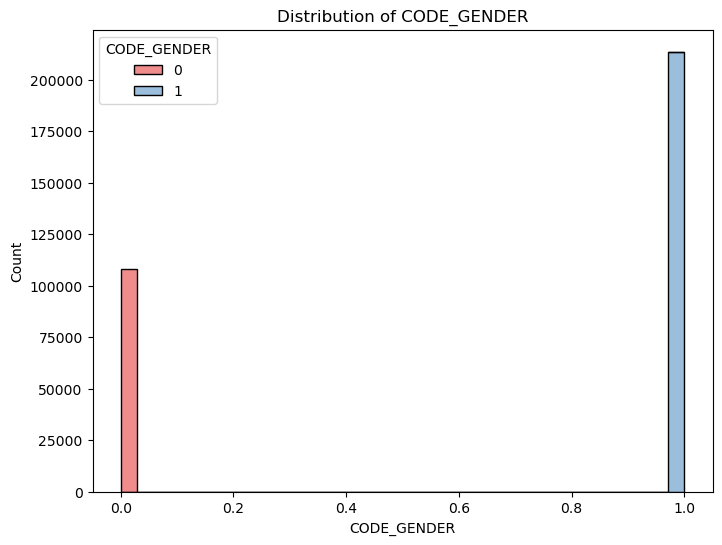

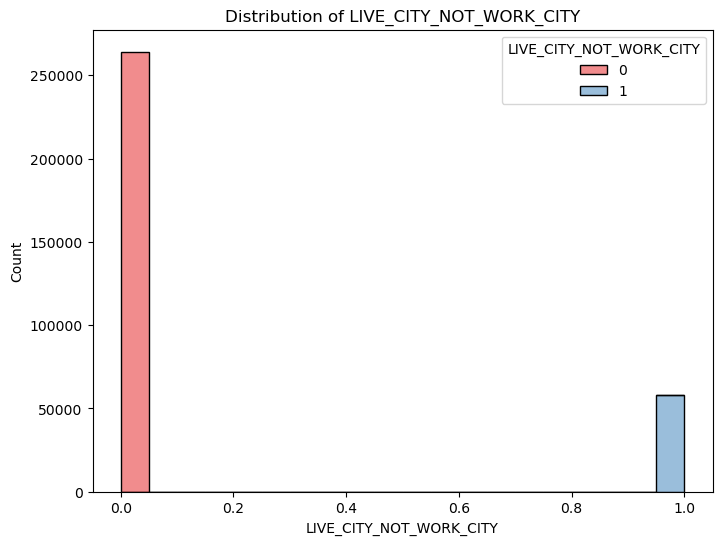

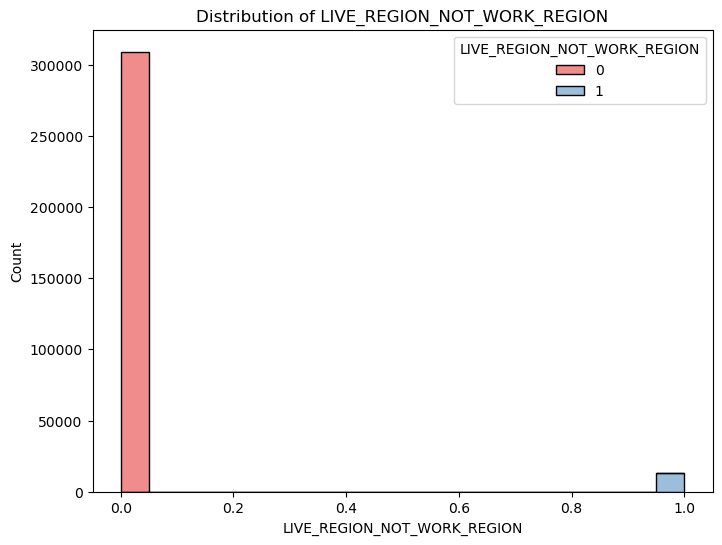

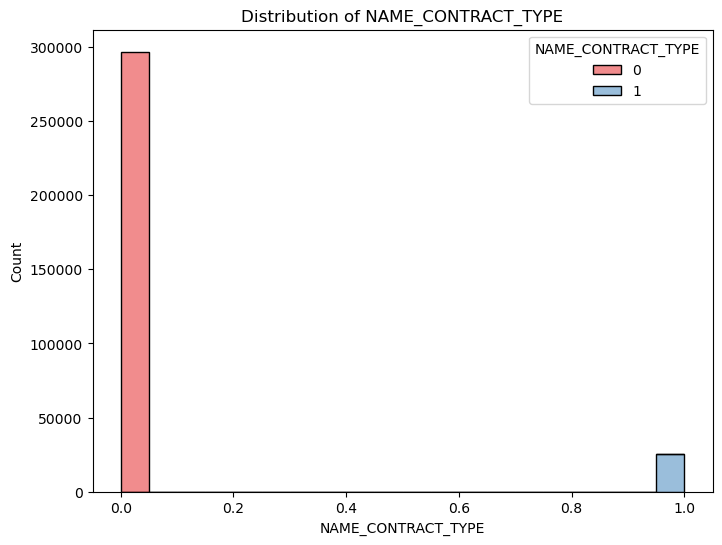

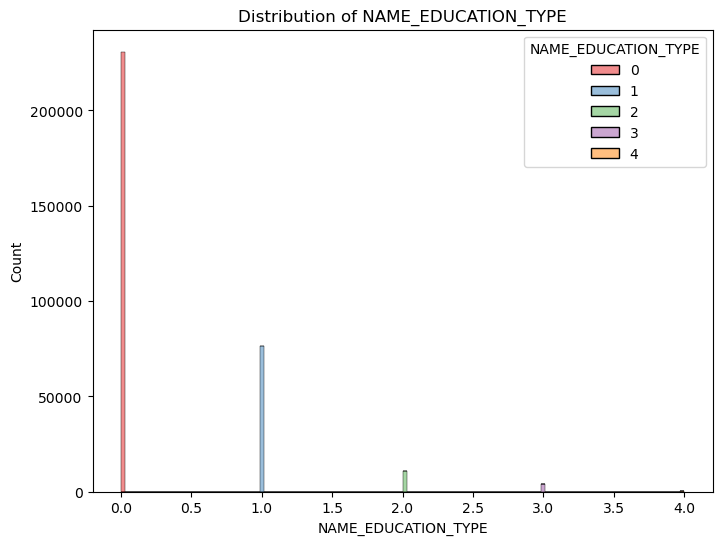

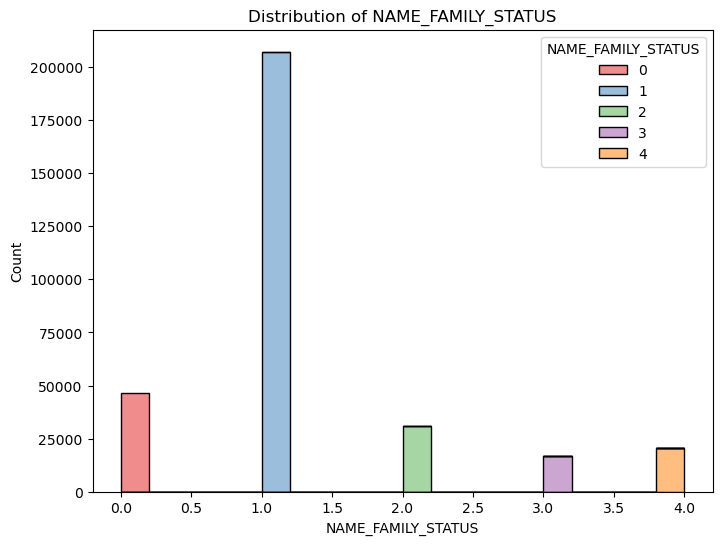

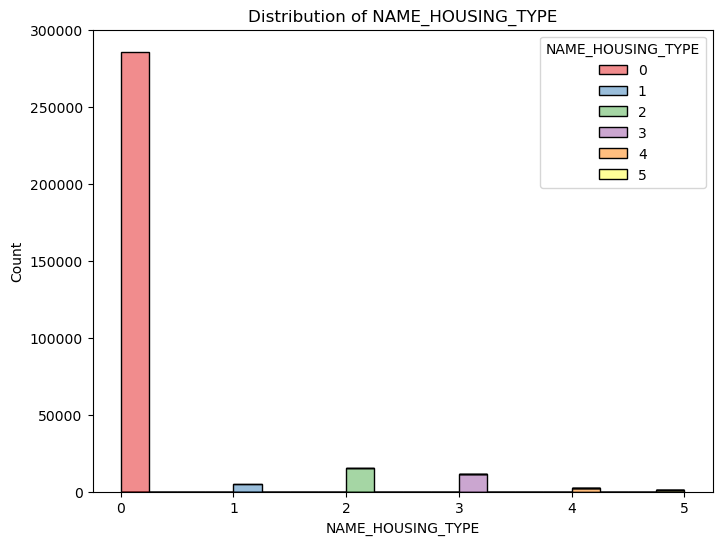

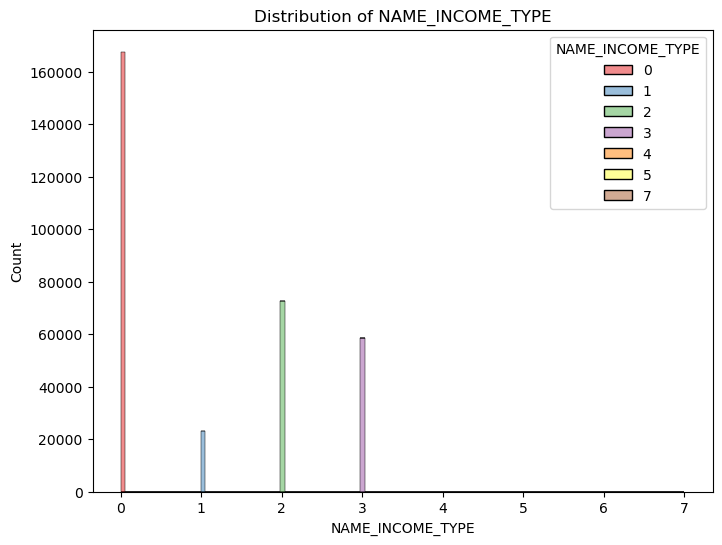

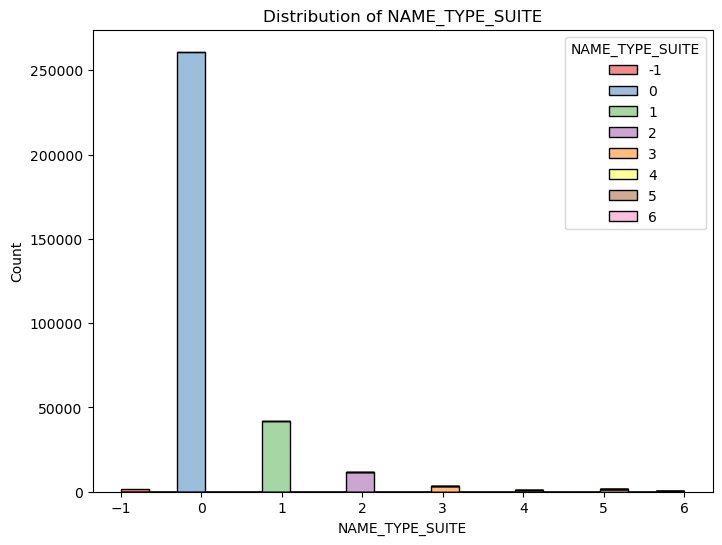

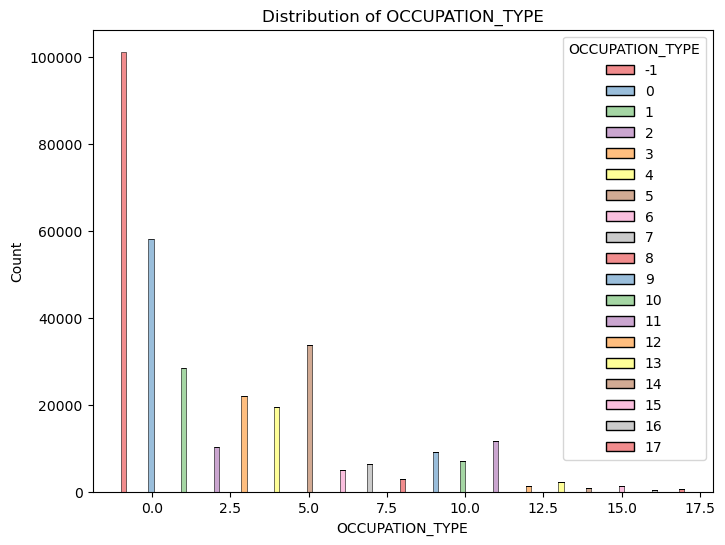

In [63]:
features_to_plot = ['CODE_GENDER',
                    'LIVE_CITY_NOT_WORK_CITY',
                    'LIVE_REGION_NOT_WORK_REGION',
                    'NAME_CONTRACT_TYPE',
                    'NAME_EDUCATION_TYPE',
                    'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE',
                    'NAME_INCOME_TYPE',
                    'NAME_TYPE_SUITE',
                    'OCCUPATION_TYPE']
plot_chart_features(df_imputed_iterative, features_to_plot)

la variable "target"

In [64]:
# Function to plot the distribution of a feature using Seaborn
def plot_chart_feature(data_frame, feature):
    plt.figure(figsize=(8, 6))
    sns.histplot(data=data_frame, x=feature, hue=feature, palette='Set1', multiple='stack')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

In [65]:
#print(df_imputed_iterative.dtypes)

In [66]:
#df_imputed_iterative['TARGET'] = df_imputed_iterative['TARGET'].astype('float32')

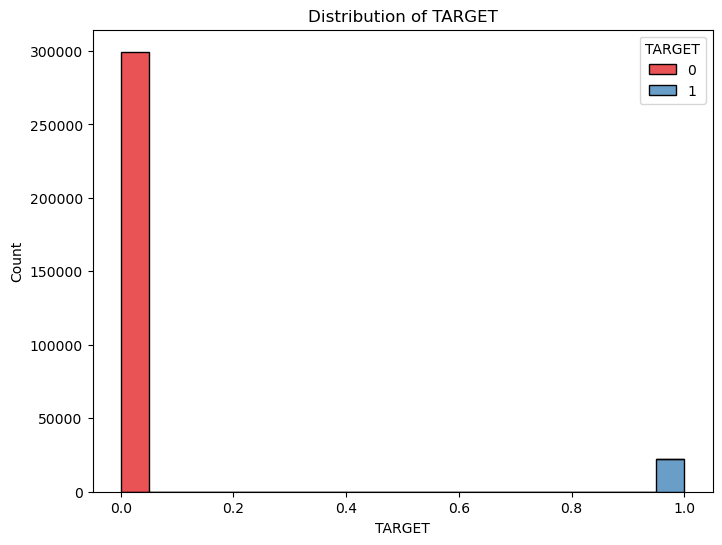

In [67]:
plot_chart_feature(df_imputed_iterative,  "TARGET")

les features numeriques importantes 

In [68]:
def plot_distribution(df, FEATURES):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(3, 2, figsize=(16, 10))

    i = 0
    for feature in FEATURES:
        if feature != 'TARGET':
            i += 1
            plt.subplot(3, 2, i)
            sns.histplot(data=df, x=feature, fill=True, color='green', alpha=0.7)
            plt.ylabel('Density plot', fontsize=12)
            plt.xlabel(feature, fontsize=12)
            plt.xticks(fontsize=12, rotation=90)
            plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

In [69]:
domain_features = ['AMT_CREDIT',
                   'DAYS_BIRTH',
                   'DAYS_EMPLOYED',
                   'AMT_INCOME_TOTAL',
                   'ANNUITY_TO_INCOME_RATIO']

In [70]:
df_imputed_iterative['DAYS_EMPLOYED'] = df_imputed_iterative['DAYS_EMPLOYED'].astype('float32')
df_imputed_iterative['ANNUITY_TO_INCOME_RATIO'] = df_imputed_iterative['ANNUITY_TO_INCOME_RATIO'].astype('float32')

/var/folders/4t/7s7tbdy15x33d8m2g7b7syv00000gn/T/ipykernel_88442/2900377635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputed_iterative['DAYS_EMPLOYED'] = df_imputed_iterative['DAYS_EMPLOYED'].astype('float32')
/var/folders/4t/7s7tbdy15x33d8m2g7b7syv00000gn/T/ipykernel_88442/2900377635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputed_iterative['ANNUITY_TO_INCOME_RATIO'] = df_imputed_iterative['ANNUITY_TO_INCOME_RATIO'].astype('float32')


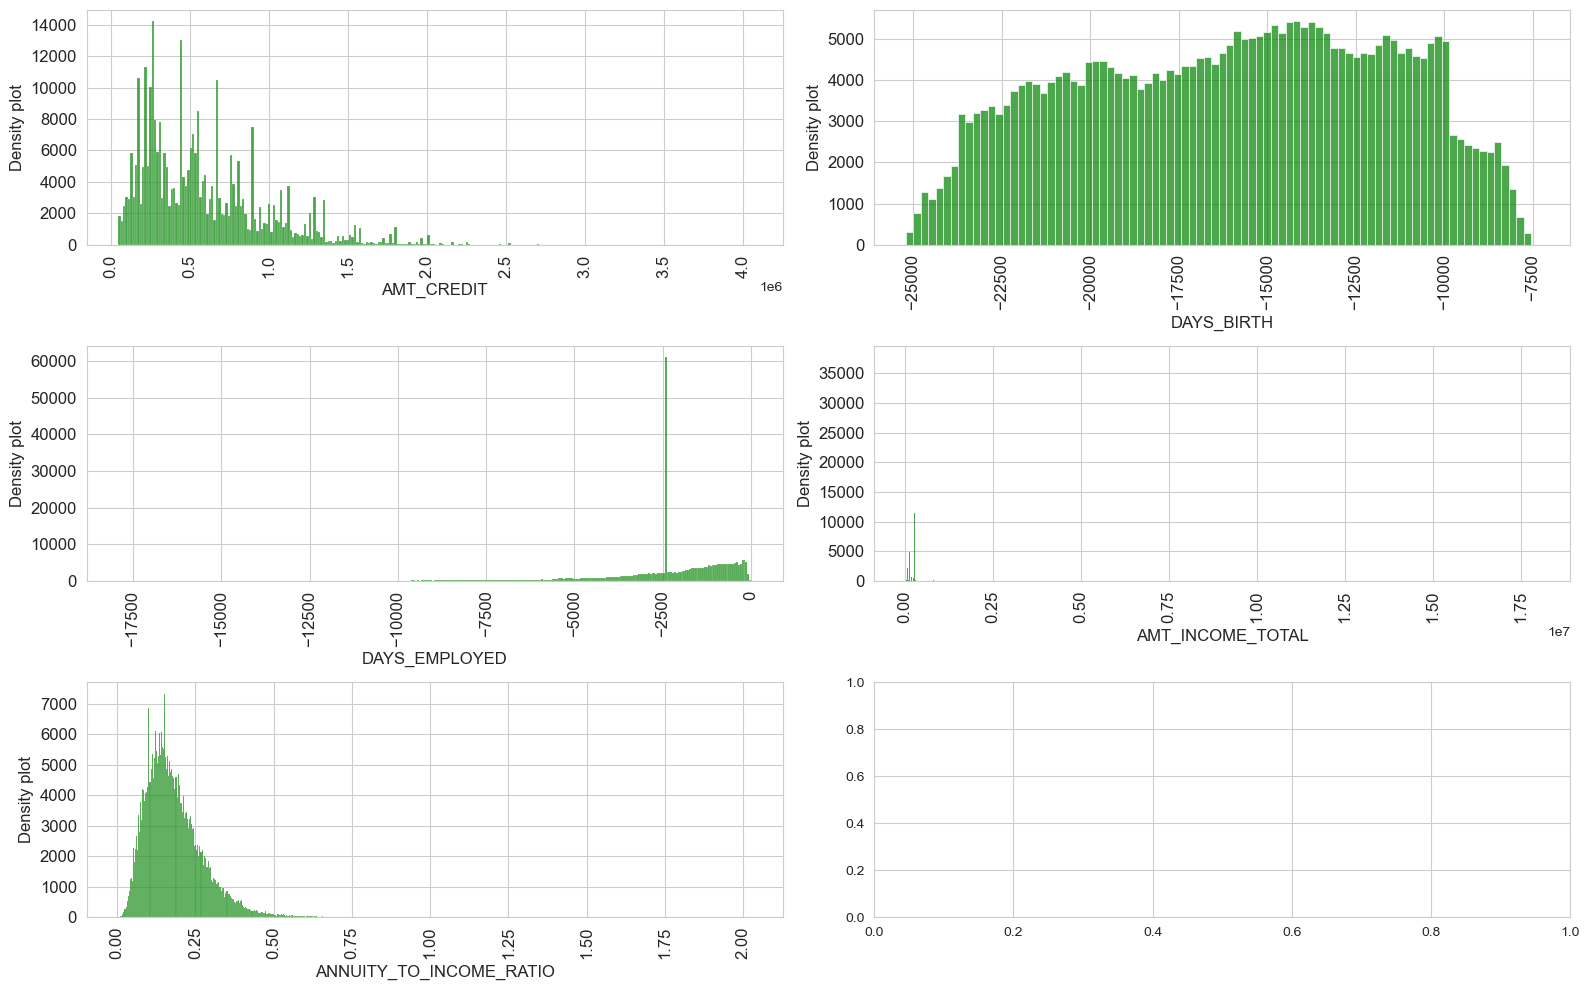

In [71]:
plot_distribution(df_imputed_iterative, domain_features)

analyse multivarivée 

In [72]:
def chart_multi(data_frame, feature1, feature2):
    plt.figure(figsize=(8, 6))
    sns.histplot(data=data_frame, x=feature1, y=feature2, kde=True, hue=feature2, palette='Set1', multiple='stack')
    plt.title(f'Distribution of {feature1} by {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

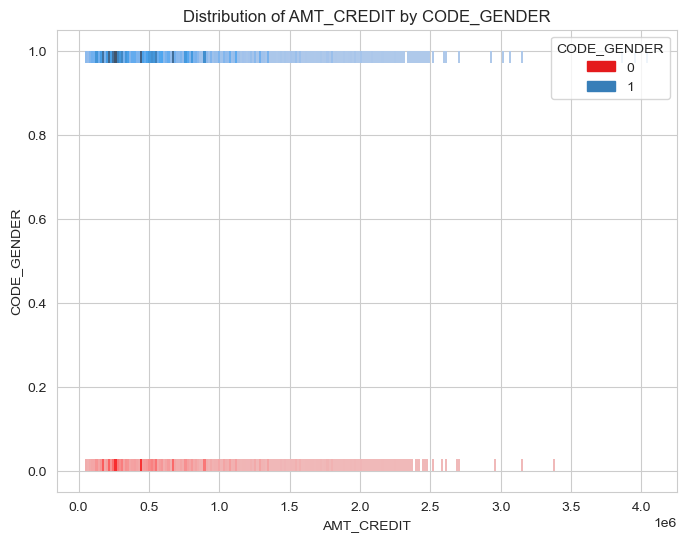

In [73]:
chart_multi(df_imputed_iterative,'AMT_CREDIT','CODE_GENDER')

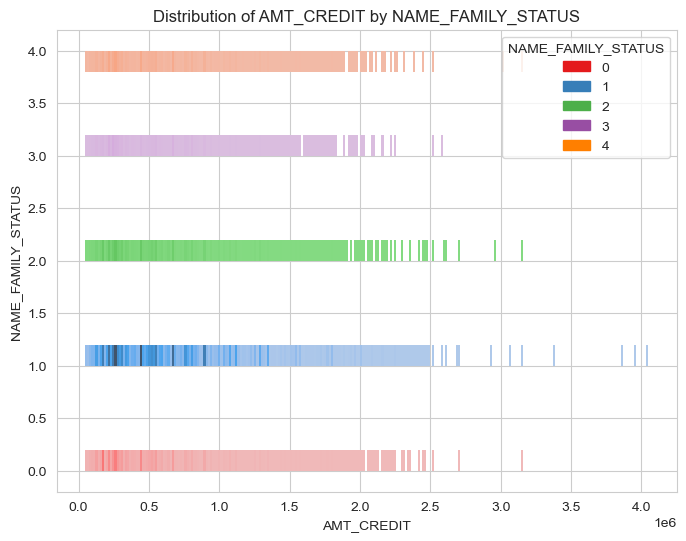

In [74]:
chart_multi(df_imputed_iterative,'AMT_CREDIT','NAME_FAMILY_STATUS')

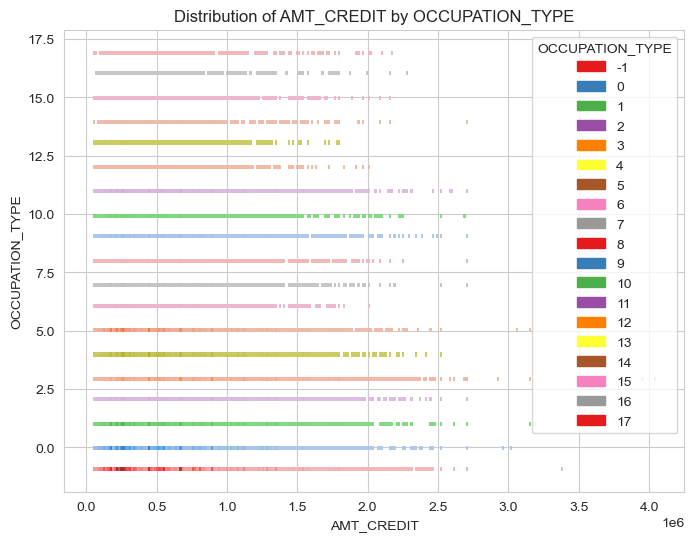

In [75]:
chart_multi(df_imputed_iterative,'AMT_CREDIT','OCCUPATION_TYPE')

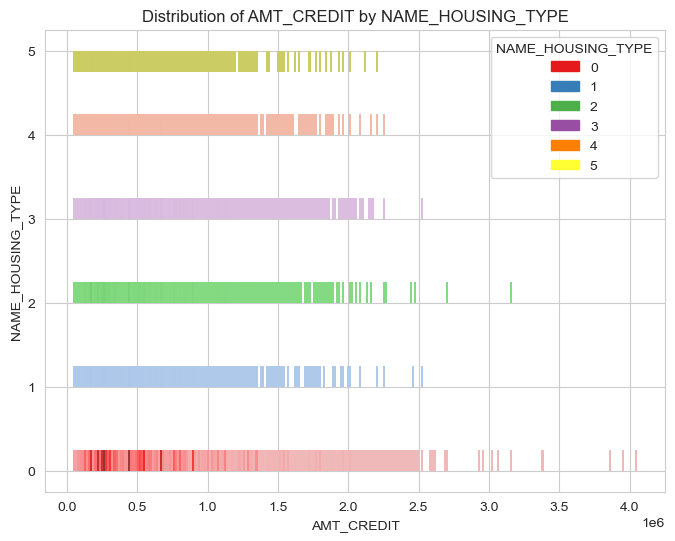

In [76]:
chart_multi(df_imputed_iterative,'AMT_CREDIT','NAME_HOUSING_TYPE')

## PARTIE II: MODELISATION

In [77]:
#pip install pandas scikit-learn imbalanced-learn

In [78]:
#!pip install imblearn

In [79]:
from sklearn.utils import _param_validation
#print(dir(_param_validation))

In [80]:
#!pip install --upgrade scikit-learn

In [81]:
#!pip install --upgrade imbalanced-learn

In [82]:
#!pip install xgboost

In [83]:
import re
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
import os

In [84]:
#set(df_imputed_iterative.columns)

In [85]:
#set(df_imputed_iterative["TARGET"])

In [86]:
# define X and y 
X = df_imputed_iterative.drop(columns = ["TARGET", "SK_ID_CURR"])
y = df_imputed_iterative['TARGET']

In [87]:
#clean and rename the features because the feature names are not accepted by ML model 
def clean_column_name(column_name):
    # Remove non-alphanumeric characters, replace spaces with underscores, and convert to uppercase
    cleaned_name = re.sub(r'\W+', ' ', column_name).strip().replace(' ', '_').upper()
    return cleaned_name

# Clean and rename the features
X.columns = [clean_column_name(col) for col in X.columns]

In [88]:
#set(X)

la fonction cout metier 

In [89]:
from sklearn.metrics import confusion_matrix, make_scorer

# Define a custom scoring function
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp

# Create a scorer from the custom scoring function
custom_scorer = make_scorer(custom_score, greater_is_better=False) 

score = 10 * fn + fp 

declarer ce score dans make search et ensuite utiliser cette valeur dans le scoring du gridseach 

ENTRAINEMENT DES MODELES 

imblanced learn

https://vitalflux.com/class-imbalance-class-weight-python-sklearn/

In [90]:
X

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,INS_LATE_PAYMENT_MEAN,INS_LATE_PAYMENT_RATIO_MEAN,INS_DPD_7_MEAN,INS_PAID_OVER_MEAN,INS_36M_AMT_INSTALMENT_MIN,INS_36M_DPD_MAX,INS_36M_DPD_VAR,CURRENT_TO_APPROVED_CREDIT_MIN_RATIO,CURRENT_TO_APPROVED_CREDIT_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO
0,0,0,0.0,202500.0,406597.5,0,0,0,0,0,...,1.000000,1.000000,0.000000,0.0,9251.775391,0.0,0.000000,0.440430,0.440430,1.175716
1,0,1,0.0,270000.0,1293502.5,1,1,1,1,0,...,1.000000,1.000000,0.000000,0.0,64275.613281,0.0,0.000000,0.052612,0.800781,0.290662
2,1,0,1.0,67500.0,135000.0,0,0,0,0,0,...,1.000000,1.000000,0.000000,0.0,5357.250000,0.0,0.000000,0.148926,0.148926,0.187652
3,0,1,0.0,135000.0,312682.5,0,0,0,2,0,...,1.000000,1.000000,0.000000,0.0,2482.919922,0.0,0.000000,0.077454,2.158203,2.643133
4,0,0,0.0,121500.0,513000.0,0,0,0,0,0,...,0.621094,0.575787,0.060608,0.0,16037.639648,2.0,0.116725,0.028488,0.554199,0.931669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338988,0,1,0.0,121500.0,412560.0,0,0,0,3,0,...,1.000000,1.000000,0.000000,0.0,14222.429688,0.0,0.000000,0.617188,0.617188,0.758487
338989,0,1,0.0,157500.0,622413.0,0,2,0,1,0,...,0.849121,0.840197,0.027405,0.0,5430.375000,2.0,0.135204,0.043030,0.335449,1.138010
338990,0,1,1.0,202500.0,315000.0,0,2,0,1,0,...,1.000000,1.000000,0.000000,0.0,12640.950195,0.0,0.000000,0.353271,0.488037,1.028232
338991,0,0,0.0,225000.0,450000.0,1,2,1,1,0,...,0.896484,0.896552,0.000000,0.0,23451.705078,0.0,0.000000,0.089905,1.008789,1.080704


In [91]:
y

0         1
1         0
2         0
3         0
4         0
         ..
338988    0
338989    0
338990    0
338991    0
338992    0
Name: TARGET, Length: 322060, dtype: int64

In [92]:
#!pip install smote

In [93]:
#!pip install -U imbalanced-learn
#!pip install -U scikit-learn
#!pip install -U threadpoolctl

In [97]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Handle class imbalance using SMOTE on the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define the preprocessing steps
preprocessor = MinMaxScaler()

# Define the models and their respective hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(), {'model__C': [0.001, 0.01, 0.1, 1, 10],
                                                   'model__penalty': ['l1', 'l2'],
                                                   'model__solver': ['liblinear']}),
    
    'Decision Tree Classifier': (DecisionTreeClassifier(), {'model__max_depth': [None, 3, 4, 5],
                                                            'model__min_samples_split': [2, 3],
                                                            'model__min_samples_leaf': [1, 2, 3],
                                                            'model__criterion': ['gini', 'entropy']}),
    
    'Random Forest Classifier': (RandomForestClassifier(), {'model__n_estimators': [50, 100, 200],
                                                            'model__max_depth': [None, 3, 4, 5],
                                                            'model__min_samples_split': [2, 3],
                                                            'model__min_samples_leaf': [1, 2, 3],
                                                            'model__class_weight': ['balanced', None]}),
    
    'XGB': (XGBClassifier(), {'model__n_estimators': [50, 100, 200],
                              'model__max_depth': [3, 4, 5],
                              'model__learning_rate': [0.01, 0.1, 0.2],
                              'model__subsample': [0.8, 1.0],
                              'model__colsample_bytree': [0.8, 1.0]}),
    
    'LGBM': (LGBMClassifier(), {'model__n_estimators': [50, 100, 200],
                                'model__max_depth': [3, 4, 5],
                                'model__learning_rate': [0.01, 0.1, 0.2],
                                'model__subsample': [0.8, 1.0],
                                'model__colsample_bytree': [0.8, 1.0],
                                'model__verbose':[-1]})
}

# MLflow setup
mlflow.set_tracking_uri("your_mlflow_tracking_uri")  # Set your MLflow tracking URI

# Iterate over models and fit/evaluate each model
for model_name, (model, param_grid) in models.items():
    # Start an MLflow run
    with mlflow.start_run():
        # Create a pipeline for the model
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

        # Measure training time
        start_time = time.time()
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1, refit=True)

        grid_search.fit(X_resampled, y_resampled)
        end_time = time.time()

        # Training time in seconds
        training_time = end_time - start_time
        print(f"Training Time ({model_name}): {training_time:.2f} seconds")

        # Log parameters, metrics, and model
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("training_time", training_time)

        # Log GridSearchCV results
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("best_cv_score", grid_search.best_score_)
        
        # Log mean test score
        mlflow.log_metric("mean_test_score", grid_search.cv_results_['mean_test_score'].mean())
        
        # Save cv_results_ to a CSV file
        cv_results_filepath = "cv_results.csv"
        pd.DataFrame(grid_search.cv_results_).to_csv(cv_results_filepath, index=False)
        mlflow.log_artifact(cv_results_filepath, "cv_results")
        
        # Log custom scorer
        #mlflow.log_metric("custom_scorer", grid_search.cv_results_['mean_test_custom_score'].mean())  # replace 'mean_test_custom_score' with the actual key

        # Print custom scorer
        #print("Custom Scorer:", grid_search.cv_results_['mean_test_custom_score'].mean())  # replace 'mean_test_custom_score' with the actual key

        
        # Print mean test score
        print("Mean Test Score:", grid_search.cv_results_['mean_test_score'].mean())


        # Log the best estimator (fitted model)
        mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")

        # Make predictions on the validation set
        y_val_pred = grid_search.predict(X_val)
        y_val_prob = grid_search.predict_proba(X_val)[:, 1]  # Probability of the positive class

        # Evaluate the model on the validation set
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_roc_auc = roc_auc_score(y_val, y_val_prob)
        val_classification_rep = classification_report(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)

        # Log validation set metrics
        mlflow.log_metric("val_accuracy", val_accuracy)
        mlflow.log_metric("val_roc_auc", val_roc_auc)
        mlflow.log_metric("val_precision", val_precision)
        mlflow.log_metric("val_recall", val_recall)
        mlflow.log_metric("val_f1", val_f1)

        # Print the best hyperparameters and validation results
        print("\nValidation Results:")
        print(f"Accuracy: {val_accuracy:.4f}")
        print(f"AUROC: {val_roc_auc:.4f}")
        print("Classification Report:\n", val_classification_rep)

        # Make predictions on the test set
        y_test_pred = grid_search.predict(X_test)
        y_test_prob = grid_search.predict_proba(X_test)[:, 1]  # Probability of the positive class

        # Evaluate the model on the test set
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_prob)
        test_classification_rep = classification_report(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)

        # Log test set metrics
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_roc_auc", test_roc_auc)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1", test_f1)

        # Print the test set results
        print("\nTest Set Results:")
        print(f"Accuracy: {test_accuracy:.4f}")
        print(f"AUROC: {test_roc_auc:.4f}")
        print("Classification Report:\n", test_classification_rep)

        # Remove the temporary CSV file
        os.remove(cv_results_filepath)

Training Time (Logistic Regression): 5717.63 seconds
Mean Test Score: -80156.29999999999


/Users/saidali_bacar/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Validation Results:
Accuracy: 0.7653
AUROC: 0.7147
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.78      0.86     59987
           1       0.15      0.51      0.23      4425

    accuracy                           0.77     64412
   macro avg       0.55      0.65      0.55     64412
weighted avg       0.90      0.77      0.82     64412


Test Set Results:
Accuracy: 0.7633
AUROC: 0.7111
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.78      0.86     59901
           1       0.15      0.51      0.23      4511

    accuracy                           0.76     64412
   macro avg       0.55      0.65      0.55     64412
weighted avg       0.90      0.76      0.82     64412



/Users/saidali_bacar/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Time (Decision Tree Classifier): 472.38 seconds
Mean Test Score: -68229.00416666667

Validation Results:
Accuracy: 0.8510
AUROC: 0.5461
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92     59987
           1       0.12      0.19      0.15      4425

    accuracy                           0.85     64412
   macro avg       0.53      0.55      0.53     64412
weighted avg       0.88      0.85      0.87     64412


Test Set Results:
Accuracy: 0.8486
AUROC: 0.5522
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92     59901
           1       0.13      0.21      0.16      4511

    accuracy                           0.85     64412
   macro avg       0.53      0.55      0.54     64412
weighted avg       0.88      0.85      0.86     64412



/Users/saidali_bacar/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Time (Random Forest Classifier): 11834.06 seconds
Mean Test Score: -49410.825000000004

Validation Results:
Accuracy: 0.9277
AUROC: 0.7355
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     59987
           1       0.28      0.03      0.06      4425

    accuracy                           0.93     64412
   macro avg       0.61      0.51      0.51     64412
weighted avg       0.89      0.93      0.90     64412


Test Set Results:
Accuracy: 0.9261
AUROC: 0.7365
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     59901
           1       0.29      0.04      0.07      4511

    accuracy                           0.93     64412
   macro avg       0.61      0.52      0.51     64412
weighted avg       0.89      0.93      0.90     64412



/Users/saidali_bacar/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Time (XGB): 946.88 seconds
Mean Test Score: -37703.68518518518

Validation Results:
Accuracy: 0.9304
AUROC: 0.7719
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     59987
           1       0.45      0.05      0.09      4425

    accuracy                           0.93     64412
   macro avg       0.69      0.52      0.53     64412
weighted avg       0.90      0.93      0.90     64412


Test Set Results:
Accuracy: 0.9291
AUROC: 0.7761
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     59901
           1       0.45      0.05      0.09      4511

    accuracy                           0.93     64412
   macro avg       0.69      0.52      0.53     64412
weighted avg       0.90      0.93      0.90     64412



/Users/saidali_bacar/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Time (LGBM): 1326.61 seconds
Mean Test Score: -36803.04074074075

Validation Results:
Accuracy: 0.9305
AUROC: 0.7721
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     59987
           1       0.45      0.06      0.10      4425

    accuracy                           0.93     64412
   macro avg       0.69      0.53      0.53     64412
weighted avg       0.90      0.93      0.90     64412


Test Set Results:
Accuracy: 0.9288
AUROC: 0.7733
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     59901
           1       0.43      0.05      0.10      4511

    accuracy                           0.93     64412
   macro avg       0.68      0.52      0.53     64412
weighted avg       0.90      0.93      0.90     64412

